# Описание проекта

Вам предоставлены пробы нефти в трёх регионах: качество нефти и объём её запасов.

Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

### Для выполенения работы нам будет необходимо:
- проанализировать и подготовить данные
- обучить модель и сделать предсказания для каждого региона
- рассчитать RMSE модели каждого региона и средних запасов
- определить необходимый минимальный запас продукта для безубыточной работы
- по предсказаниям модели опредилить лучшие месторождения в каждом регионе и почитать суммарную прибыль и запасы продукта
- с помощью метода **BOOTSTRAP** определить среднюю прибыль и риск убытков
- определить регион для разгработки и обосновать выбор



# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

Загрузим данные и взглянем на них:

In [2]:
region_data_1 = pd.read_csv('data_0.csv')
region_data_2 = pd.read_csv('data_1.csv')
region_data_3 = pd.read_csv('data_2.csv')
regions = [region_data_1, region_data_2, region_data_3]

In [3]:
for region in regions:
    print(region)

          id        f0        f1        f2     product
0      txEyH  0.705745 -0.497823  1.221170  105.280062
1      2acmU  1.334711 -0.340164  4.365080   73.037750
2      409Wp  1.022732  0.151990  1.419926   85.265647
3      iJLyR -0.032172  0.139033  2.978566  168.620776
4      Xdl7t  1.988431  0.155413  4.751769  154.036647
...      ...       ...       ...       ...         ...
99995  DLsed  0.971957  0.370953  6.075346  110.744026
99996  QKivN  1.392429 -0.382606  1.273912  122.346843
99997  3rnvd  1.029585  0.018787 -1.348308   64.375443
99998  7kl59  0.998163 -0.528582  1.583869   74.040764
99999  1CWhH  1.764754 -0.266417  5.722849  149.633246

[100000 rows x 5 columns]
          id         f0         f1        f2     product
0      kBEdx -15.001348  -8.276000 -0.005876    3.179103
1      62mP7  14.272088  -3.475083  0.999183   26.953261
2      vyE1P   6.263187  -5.948386  5.001160  134.766305
3      KcrkZ -13.081196 -11.506057  4.999415  137.945408
4      AHL4O  12.702195  -8.

Датасеты представляют из себя данные каждого региона по 100000 месторождений, включая:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Взглянем на разброс данных, на наличие выбросов и пропусков:

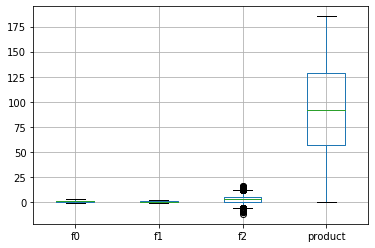

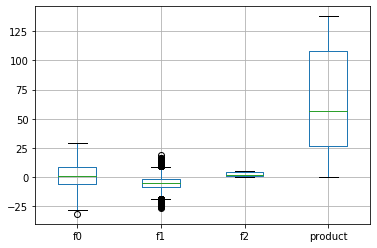

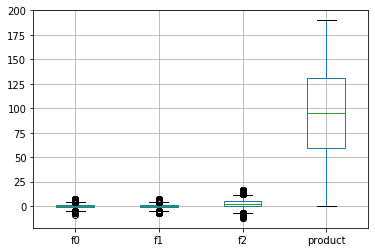

In [4]:
for region in regions:
    fig = plt.figure()
    region.boxplot()

In [5]:
for region in regions:
    print(region.isnull().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Выбросы есть, но совем небольшие, оставим данные вы исходном виде. Пропусков нет

**Удалим столбец с id в каждом регионе**, он нам не нужен:

In [6]:
region_data_1 = region_data_1.drop('id', axis=1)
region_data_2 = region_data_2.drop('id', axis=1)
region_data_3 = region_data_3.drop('id', axis=1)

# 2. Обучение и проверка модели

**Разделим данные на обучающую и валидационную выборки в соотношении 75:25 для каждого региона:**

In [7]:
def split_df(region):
    target = region['product']
    features = region.drop('product', axis=1)

    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [8]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_df(region_data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_df(region_data_2)
features_train_3, features_valid_3, target_train_3, target_valid_3 = split_df(region_data_3)

**Обучим и проверим модели для каждого региона:**

In [9]:
def training_validation_model(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    predicted = pd.Series(predicted, index=target_valid.index) #преобразуем в Series с индексами целевого признака
    return predicted

**Получим предсказания:**

In [10]:
predicted_1 = training_validation_model(features_train_1, target_train_1, features_valid_1, target_valid_1)
predicted_2 = training_validation_model(features_train_2, target_train_2, features_valid_2, target_valid_2)
predicted_3 = training_validation_model(features_train_3, target_train_3, features_valid_3, target_valid_3)

**Расчет RMSE модели каждого региона и средних запасов:**

In [11]:
def rmse_and_mean_prod(region, target_valid, predicted):
    RMSE = (mean_squared_error(target_valid, predicted)**0.5).round(2)
    mean_product = (region['product'].mean()).round(2)
    return RMSE,  mean_product
RMSE_1,  mean_product_1 = rmse_and_mean_prod(region_data_1, target_valid_1, predicted_1)
RMSE_2,  mean_product_2 = rmse_and_mean_prod(region_data_2, target_valid_2, predicted_2)
RMSE_3,  mean_product_3 = rmse_and_mean_prod(region_data_3, target_valid_3, predicted_3)

Соберем результаты в таблицу:

In [12]:
data_rmse_and_mean_prod = [['1', RMSE_1,  mean_product_1],
                 ['2', RMSE_2,  mean_product_2],
                 ['3', RMSE_3,  mean_product_3]
                ]
df_rmse_and_mean_prod = pd.DataFrame(data_rmse_and_mean_prod, columns = ['Регион', 'RMSE', 'Ср. запас'])

Подозрительный результат RMSE у региона 2, модель практически не ошибается, возможно там произошла "утечка" целевого признака, проверим корреляцию:

In [13]:
region_data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Корреляция признака f2 и запасов практически 1. Мы не знаем, что это за признак, в реальной задаче стоило бы обратиться к заказчику по этому вопросу. А пока решающих выводов по второму региону делать не стоит

### Вывод

Мы **обучили модели линейной регрессии** для каждого региона и посчитали **средний запас продукта**:

In [14]:
df_rmse_and_mean_prod

,Регион,RMSE,Ср. запас
0,1,37.58,92.50
1,2,0.89,68.83
2,3,40.03,95.00


- в данных региона произошла "утечка" целевого признака, поэтому на будущие предсказания модели полагатсья не стоит
- в части **качества предсказаний лучший результат у региона № 1 - RMSE = 37,58**
- в части **среднийх запасов чуть лучший результат показал регион № 3**

# 3. Подготовка к расчёту прибыли

Заведем все необходимые данные:

In [15]:
BUDGET = 10 # бюджет на разработку региона, млрд
INCOME_BARREL = 450000 # доход с одного барреля
BUDGET_ONE_FIELD = BUDGET/200 # стоимость разработки месторождения (делим на число скважин)

Рассчитаем **минимальный объем запаса в месторождении** для его безубыточной разработки.

Для чего поделим стоимость разработки месторождения на доход с одного барреля:

In [16]:
MINIMUM_VOLUME = BUDGET_ONE_FIELD/INCOME_BARREL
MINIMUM_VOLUME

1.1111111111111112e-07

**Минимальный запас равен 111.(1)** - ощутимо больше средних запасов в каждом регионе (92.50, 68.83, 95.00)

### Вывод
- **Необходимый минимальный запас должен быть не меньше 111.1 барреля** в каждом месторождении, чтобы "выйти в ноль"
- **средние значения в каждом регионе (92.50, 68.83, 95.00) меньше этого значения**, возможно выбор самых лучших месторождений внутри каждого региона позволит преодолеть порог запаса в 111,1

# 4. Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [17]:
def sum_target(predicted, target_valid):
    predicted_sorted = predicted.sort_values(ascending=False) # сортируем предсказания по убыванию
    selected = target_valid[predicted_sorted.index][:200] # берем 200 соответствующих результатов
    sum_target = selected.sum().round(2) # суммируем запасы
    total_profit = (sum_target * INCOME_BARREL/1000000000 - BUDGET).round(3) # считаем прибыль (10 - стоимость разработки)
    return sum_target, total_profit

Определим суммарный запас и прибыль:

In [18]:
product_sum_target_1, total_profit_1 = sum_target(predicted_1, target_valid_1)
product_sum_target_2, total_profit_2 = sum_target(predicted_2, target_valid_2)
product_sum_target_3, total_profit_3 = sum_target(predicted_3, target_valid_3)

In [19]:
data_top = [['1', product_sum_target_1, total_profit_1],
                 ['2', product_sum_target_2, total_profit_2],
                 ['3', product_sum_target_3, total_profit_3]
                ]
df_top = pd.DataFrame(data_top, columns = ['Регион', 'Запас, тыс','Прибыль, млрд'])
df_top

,Регион,"Запас, тыс","Прибыль, млрд"
0,1,29601.84,3.321
1,2,27589.08,2.415
2,3,28245.22,2.710


## Расчет рисков

Напишем функцию, которая будет производить операцию bootstrap:
1. 1000 раз делать выборку 500ста произвольных месторождений
2. Из которых будет выбирать 200 лучших по предскзаниями
3. Давать общую (на 1000 результатов) среднюю прибыль с дверительным интервалом и риск убытков:

In [20]:
state = np.random.RandomState(12345)

def bootstrap(target, predicted):
    values = []
    
    for i in range(1000):
        target_subsample = target.sample(frac=0.02, replace=True, random_state=state) # выбираем 500 месторождений
        probs_subsample = predicted[target_subsample.index] # и соответствующие предсказания
        sum_target_1, total_profit_1 = sum_target(probs_subsample, target_subsample) # считаем прибыль
    
        values.append(total_profit_1) # сохраняем значение прибыли

    values = pd.Series(values) # переводим в Series
    
    # Средняя выручка:
    mean = values.mean().round(4)
        
    # Вероятность убытков = соотношение результатов, которые меньше 10 млрд., к общему числу расчетов:
    probability_of_losses = (values < 0).sum()/1000
    
    # Доверительынй интервал:
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    print('Доверительный интервал = ', confidence_interval)
    
    lower = values.quantile(0.025).round(2)
    upper = values.quantile(0.975).round(2)
    
    return mean, probability_of_losses, lower, upper

In [21]:
mean_1, probability_of_losses_1, lower_1, upper_1 = bootstrap(target_valid_1, predicted_1)
mean_2, probability_of_losses_2, lower_2, upper_2 = bootstrap(target_valid_2, predicted_2)
mean_3, probability_of_losses_3, lower_3, upper_3 = bootstrap(target_valid_3, predicted_3)

In [22]:
data_bootstrap = [['1', mean_1, (lower_1, upper_1), probability_of_losses_1],
                 ['2', mean_2, (lower_2, upper_2), probability_of_losses_2],
                 ['3', mean_3, (lower_3, upper_3), probability_of_losses_3]
                ]
df_bootstrap = pd.DataFrame(data_bootstrap, columns = ['Регион', 'Ср. прибыль', 'Дов. интервал' , 'Риск убытков'])
df_bootstrap.set_index('Регион')

,Ср. прибыль,Дов. интервал,Риск убытков
Регион,,,
1,0.4259,"(-0.1, 0.95)",0.060
2,0.5183,"(0.13, 0.95)",0.002
3,0.4202,"(-0.12, 0.99)",0.061


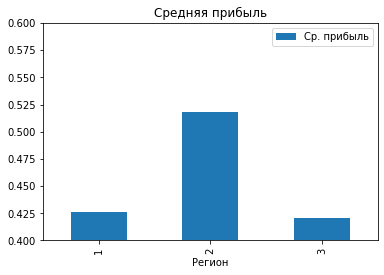

In [23]:
df_bootstrap.plot(kind='bar', y='Ср. прибыль', x='Регион')
plt.title('Средняя прибыль')
plt.ylim(0.4, 0.6)
plt.show()

Регион № 2 имеет лучшие показатели, вызвано это тем, что модель из-за "утечки" целевого признака раз за разом лучше угадывает 200 лучших месторождений из предложенных 500, а не потому, что в регионе месторождения лучше.

**Приоритетным выглядит разработка региона № 1**, так как по сравнению с регионом № 2 имеет:
- **бОльшую среднюю прибыль - 0,4259**;
- **меньший риск убытков - 0,06** 

### ОБЩИЕ ВЫВОДЫ
1. Мы **обучили модели линейной регрессии** для каждого региона и посчитали **средний запас продукта**:

In [24]:
df_rmse_and_mean_prod

,Регион,RMSE,Ср. запас
0,1,37.58,92.50
1,2,0.89,68.83
2,3,40.03,95.00


    - в данных региона №2 произошла "утечка" целевого признака, поэтому на будущие предсказания региона полагатсья не стоит;
    - в части качества предсказаний лучший результат у региона № 1 - RMSE = 37,58 против 40.03;
    - в части среднийх запасов чуть лучший результат показал регион № 3 - 95 против 92,5.

2. Определили **необходимый минимальный запас продукта для безубыточной работы - 111.12 барреля**

3. По предсказаниям модели **опредилили 200 лучших месторождений** в каждом регионе и почитали **суммарную прибыль и запасы продукта**:

In [25]:
df_top

,Регион,"Запас, тыс","Прибыль, млрд"
0,1,29601.84,3.321
1,2,27589.08,2.415
2,3,28245.22,2.710


4. С помощью метода bootstrap **определили среднюю прибыль и риск убытков**, если "в боевых условиях" по предсказаниям модели выбирать 200 месторождений из 500 случайных в каждом регионе:

In [26]:
df_bootstrap

,Регион,Ср. прибыль,Дов. интервал,Риск убытков
0,1,0.4259,"(-0.1, 0.95)",0.060
1,2,0.5183,"(0.13, 0.95)",0.002
2,3,0.4202,"(-0.12, 0.99)",0.061


Таким образом, свое **внимание стоит сконцентрировать на регионе № 1, так как он имеет лучшие показатели по средней прибыли - 0.4259 млрд. и риску убытков - 0.06** (регион 2 в расчет не берем, так как его показатели условлены некорректными данными).

Кроме того, согласно расчетам, **в регионе № 1 у лучших 200 месторождений наибольшие запасы 29601.84 и прибыль 3.321** по сравнению с ТОП-200 скважин других регионов.